In [17]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [18]:
rng = np.random.default_rng(42)
df = pd.read_csv('datasets/uncontrollable_sample.csv', index_col = 'id')

In [19]:
df.columns.values

array(['idpop_local_sum', 'idpop_citywide_sum', 'idpop_local_food_sum',
       'idpop_citywide_food_sum', 'idpop_local_nightlife_sum',
       'idpop_citywide_nightlife_sum', 'idpop_local_travel_sum',
       'idpop_citywide_travel_sum', 'venue_count_500m', 'sub_cnt_20m',
       'sub__line_cnt_20m', 'comp', 'comp_hotel',
       'Demo % - ACS 2011 Means of transportation: Public transportation - Subway - Zipcode',
       'Demo % - Age - Age 00 - 14 - Zipcode - ACS 2011',
       'Demo % - Age - Age 15 - 29 - Zipcode - ACS 2011',
       'Demo % - Age - Age 30 - 44 - Zipcode - ACS 2011',
       'Demo % - Age - Age 45 - 59 - Zipcode - ACS 2011',
       'Demo % - Age - Age 60 + - Zipcode - ACS 2011',
       'Demo % - Education - Pop 25 yrs + Bachelors Degree - Zipcode - ACS 2011',
       'Demo % - Education - Pop 25 yrs + Masters degree - Zipcode - ACS 2011',
       'Demo % - Ethnicity - Non-White Population - Zipcode - ACS 2011',
       'Demo % - Households - Household Size: 1-2 Persons - Zip

## Building a baseline LR model using all features

Split and normalize data (using all features):

In [74]:
X_train0, X_test0, Y_train0, Y_test0 = train_test_split(df.drop('Label', 1), df.Label, test_size = 0.2, random_state = 42)

scaler = StandardScaler().fit(X_train0)
X_train_scaled0 = pd.DataFrame(scaler.transform(X_train0), columns = df.drop('Label', 1).columns)
X_test_scaled0 = pd.DataFrame(scaler.transform(X_test0), columns = df.drop('Label', 1).columns)

### Baseline model (all features):

In [102]:
lr0 = linear_model.LogisticRegression(max_iter = 2000, solver = 'saga')
lr0.fit(X_train_scaled0, Y_train0)
Y_pred = lr0.predict_proba(X_test_scaled0)[:,1]

fpr_lr0, tpr_lr0, thresholds_lr0 = metrics.roc_curve(Y_test0, Y_pred)
auc_lr0 = metrics.auc(fpr_lr0, tpr_lr0)
acc_lr0 = np.mean(np.abs(Y_test0 - Y_pred))

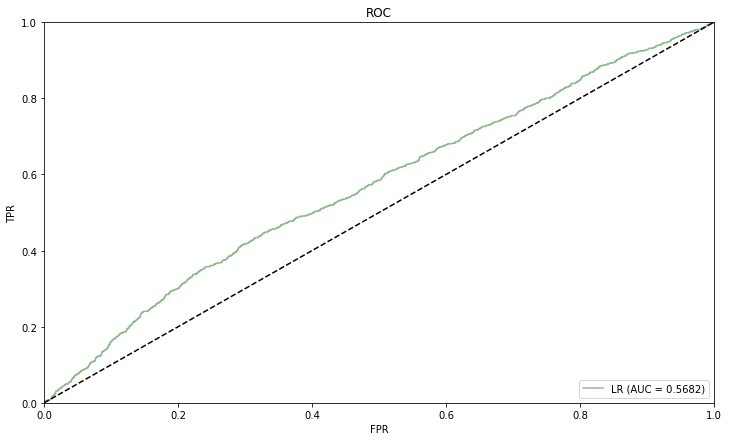

In [104]:
fig = plt.figure(figsize = (12,7))

plt.plot(fpr_lr0, tpr_lr0, color = "darkseagreen", label = "LR (AUC = {:0.4f})".format(auc_lr0))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc = 'lower right')

plt.show()

This is a promising start, but we can try to tune the features and hyperparameters in order to make this better.

### Hyperparameter selection

In [75]:
from sklearn.model_selection import KFold

def LRValAUC(X_tr, Y_tr, k, cs):
    '''
    Perform k-fold cross validation on logistic regression, varies C and penalty Type (L1 or L2),
    returns a dictionary where key=c,value=[auc-c1, auc-c2, ...auc-ck].
    '''
    cv = KFold(n_splits=k)
    aucs = {}
    accs = {}

    for train_index, test_index in cv.split(X_tr):
        X_tr_f = X_tr.iloc[train_index]
        X_va_f = X_tr.iloc[test_index]
        Y_tr_f = Y_tr.iloc[train_index]
        Y_va_f = Y_tr.iloc[test_index]
        
        for c in cs:
            for norm in [1,2]:
                lr = linear_model.LogisticRegression(C=c, penalty='l{}'.format(norm), max_iter = 2000, solver = 'saga')
                lr.fit(X_tr_f,Y_tr_f)
                
                Y_pred = lr.predict_proba(X_va_f)[:,1]
                met = metrics.roc_auc_score(Y_va_f, Y_pred)
                acc = np.mean(np.abs(Y_va_f - Y_pred))

                if (c, norm) in aucs:
                    aucs[(c, norm)].append(met)
                    accs[(c, norm)].append(acc)
                else:
                    aucs[(c, norm)] = [met]
                    accs[(c, norm)] = [acc]
    
    return aucs, accs

In [78]:
# Use 10-fold cross validation for C in 10^-10 to 10^2 and for both penalty types
k = 10
exps = np.arange(-10,2,0.5)
auc_cv_allfeats, acc_cv_allfeats = LRValAUC(X_train_scaled0, Y_train0, k, [10**i for i in exps])

In [80]:
# Dictionary of results from cross validation
xval_dict_all = {'e':[], 'mu':[], 'sig':[], 'norm':[]}

for i in exps:
    for norm in [1, 2]:
        xval_dict_all['e'].append(i)
        xval_dict_all['norm'].append(norm)
        xval_dict_all['mu'].append(np.array(auc_cv_allfeats[(10**i, norm)]).mean())
        xval_dict_all['sig'].append(np.sqrt(np.array(auc_cv_allfeats[(10**i, norm)]).var()))

xvals_all = pd.DataFrame(xval_dict_all)
xvals_all['low'] = xvals_all['mu']-xvals_all['sig']/np.sqrt(k)
xvals_all['up'] = xvals_all['mu']+xvals_all['sig']/np.sqrt(k)

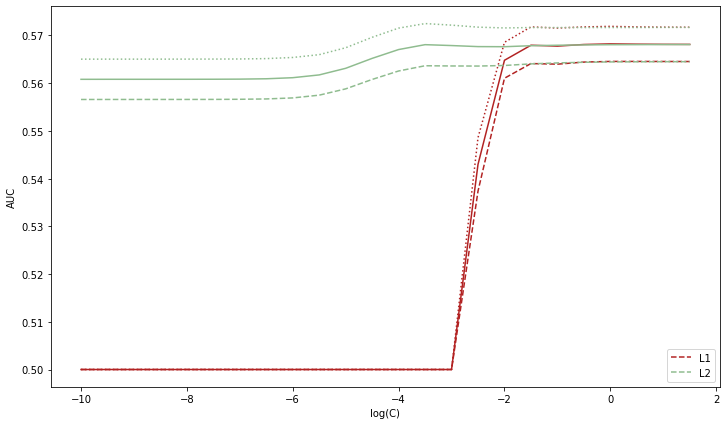

In [81]:
fig = plt.figure(figsize = (12, 7))

norm = 1
plt.plot(xvals_all['e'][(xvals_all['norm']==norm)], xvals_all['mu'][(xvals_all['norm']==norm)], 'firebrick')
plt.plot(xvals_all['e'][(xvals_all['norm']==norm)], xvals_all['low'][(xvals_all['norm']==norm)], color = 'firebrick', linestyle = '--', label='L1')
plt.plot(xvals_all['e'][(xvals_all['norm']==norm)], xvals_all['up'][(xvals_all['norm']==norm)], color = 'firebrick', linestyle = ':')

norm = 2
plt.plot(xvals_all['e'][(xvals_all['norm']==norm)], xvals_all['mu'][(xvals_all['norm']==norm)], 'darkseagreen')
plt.plot(xvals_all['e'][(xvals_all['norm']==norm)], xvals_all['low'][(xvals_all['norm']==norm)], color = 'darkseagreen', linestyle = '--', label='L2')
plt.plot(xvals_all['e'][(xvals_all['norm']==norm)], xvals_all['up'][(xvals_all['norm']==norm)], color = 'darkseagreen', linestyle = ':')

plt.xlabel('log(C)')
plt.ylabel('AUC')
plt.legend(loc=4)

plt.show()

From this, it doesn't seem as if there's a hyperparameter combination that will perform better than our baseline model. We'll look at removing features below as a way to perhaps improve model generalizability.

## Feature selection

We'll use the top 12 features in terms of information revealed from the decision tree classifier to create a subset of the features we use for modeling. We could use stepwise selection, but over 229 features and 20,000 instances, that will take too long. Let's instead take the top features identified by importance by the decision tree and see if we can better tune the parameters. 

In [82]:
df.columns.values[:32]

array(['idpop_local_sum', 'idpop_citywide_sum', 'idpop_local_food_sum',
       'idpop_citywide_food_sum', 'idpop_local_nightlife_sum',
       'idpop_citywide_nightlife_sum', 'idpop_local_travel_sum',
       'idpop_citywide_travel_sum', 'venue_count_500m', 'sub_cnt_20m',
       'sub__line_cnt_20m', 'comp', 'comp_hotel',
       'Demo % - ACS 2011 Means of transportation: Public transportation - Subway - Zipcode',
       'Demo % - Age - Age 00 - 14 - Zipcode - ACS 2011',
       'Demo % - Age - Age 15 - 29 - Zipcode - ACS 2011',
       'Demo % - Age - Age 30 - 44 - Zipcode - ACS 2011',
       'Demo % - Age - Age 45 - 59 - Zipcode - ACS 2011',
       'Demo % - Age - Age 60 + - Zipcode - ACS 2011',
       'Demo % - Education - Pop 25 yrs + Bachelors Degree - Zipcode - ACS 2011',
       'Demo % - Education - Pop 25 yrs + Masters degree - Zipcode - ACS 2011',
       'Demo % - Ethnicity - Non-White Population - Zipcode - ACS 2011',
       'Demo % - Households - Household Size: 1-2 Persons - Zip

In [93]:
df_filtered = df[['idpop_local_sum', 'idpop_citywide_sum', 'idpop_local_food_sum',
       'idpop_citywide_food_sum', 'idpop_local_nightlife_sum',
       'idpop_citywide_nightlife_sum', 'idpop_local_travel_sum',
       'idpop_citywide_travel_sum', 'venue_count_500m', 'sub_cnt_20m',
       'sub__line_cnt_20m', 'comp', 'comp_hotel',
       'Demo % - ACS 2011 Means of transportation: Public transportation - Subway - Zipcode',
       'Demo % - Age - Age 00 - 14 - Zipcode - ACS 2011',
       'Demo % - Age - Age 15 - 29 - Zipcode - ACS 2011',
       'Demo % - Age - Age 30 - 44 - Zipcode - ACS 2011',
       'Demo % - Age - Age 45 - 59 - Zipcode - ACS 2011',
       'Demo % - Age - Age 60 + - Zipcode - ACS 2011',
       'Demo % - Education - Pop 25 yrs + Bachelors Degree - Zipcode - ACS 2011',
       'Demo % - Education - Pop 25 yrs + Masters degree - Zipcode - ACS 2011',
       'Demo % - Ethnicity - Non-White Population - Zipcode - ACS 2011',
       'Demo % - Households - Household Size: 1-2 Persons - Zipcode - ACS 2011',
       'Demo % - Households - Household Size: 3+ Persons - Zipcode - ACS 2011',
       'Demo % - Households - Household Size: 7 + Persons - Zipcode - ACS 2011',
       'Demo % - Income - Hhld Income $100,000 + % - Zipcode - ACS 2011',
       'Demo % - Population - Female Population - Zipcode - ACS 2011',
       'Demo % - Population - Male Population - Zipcode - ACS 2011',
       'Demo - Age - Median Age Total Population - Zipcode - ACS 2011',
       'Demo - Households - Median Household Income - Zipcode - ACS 2011',
       'Demo - Population Density - Total - Zipcode - ACS 2011', 'Label']]

X_train, X_test, Y_train, Y_test = train_test_split(df_filtered.drop('Label', 1), df_filtered.Label, test_size = 0.2, random_state = 42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = df_filtered.drop('Label', 1).columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = df_filtered.drop('Label', 1).columns)

### Baseline model with feature subset

In [106]:
lr = linear_model.LogisticRegression(max_iter = 2000, solver = 'saga')
lr.fit(X_train_scaled, Y_train)
Y_pred = lr.predict_proba(X_test_scaled)[:,1]

fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(Y_test, Y_pred)
auc_lr = metrics.auc(fpr_lr, tpr_lr)
acc_lr = np.mean(np.abs(Y_test - Y_pred))

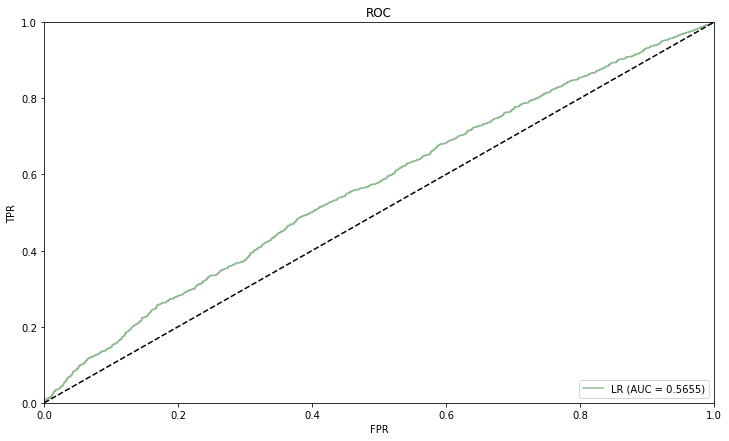

In [107]:
fig = plt.figure(figsize = (12,7))

plt.plot(fpr_lr, tpr_lr, color = "darkseagreen", label = "LR (AUC = {:0.4f})".format(auc_lr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc = 'lower right')

plt.show()

### Hyperparameter selection (ii)

Now, we'll repeat the process of hyperparameter selection for the smaller subset of features, but instead, we'll try using random search, since we have a better idea of where the optimal values might lie in the parameter grid.

In [123]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameters over which to search
param_grid = [
    {'C': np.logspace(-3.5, 0, num = 1000), 
     'penalty': ['l1', 'l2'],
    'solver': ['saga']}
]

scores = ['roc_auc', 'accuracy']

lr_RS = RandomizedSearchCV(linear_model.LogisticRegression(), param_grid, scoring = scores, 
                     cv = 5, refit = scores[0], n_jobs = -1)
lr_RS.fit(X_train_scaled, Y_train)

/Users/connor/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions=[{'C': array([3.16227766e-04, 3.18789129e-04, 3.21371239e-04, 3.23974263e-04,
       3.26598371e-04, 3.29243733e-04, 3.31910523e-04, 3.34598912e-04,
       3.37309077e-04, 3.40041193e-04, 3.42795439e-04, 3.45571994e-04,
       3.48371038e-04, 3.51192753e-04, 3.54037324e-04, 3.56904935e-04,
       3.59795772e-...
       8.57893611e-01, 8.64842328e-01, 8.71847327e-01, 8.78909065e-01,
       8.86028002e-01, 8.93204600e-01, 9.00439326e-01, 9.07732653e-01,
       9.15085053e-01, 9.22497005e-01, 9.29968993e-01, 9.37501502e-01,
       9.45095022e-01, 9.52750047e-01, 9.60467077e-01, 9.68246612e-01,
       9.76089159e-01, 9.83995230e-01, 9.91965337e-01, 1.00000000e+00]),
                                         'penalty': ['l1', 'l2'],
                                         'solver': ['saga']}],
                   refit='roc_auc', scoring=['roc_auc', 'accuracy'])

In [126]:
lr_RS.best_params_

{'solver': 'saga', 'penalty': 'l2', 'C': 0.4572567867791303}

From the plot, it seems the optimal hyperparameters are $C = 10^{-1.5}$ and penalty = $l_1$. Even so, the AUC leaves a lot to be desired. It could be that there are non-linear relationships in the data that another model would be better able to learn.

In [127]:
lr_best = linear_model.LogisticRegression(C = lr_RS.best_params_['C'], penalty = 'l2', max_iter = 2000, solver = 'saga')
lr_best.fit(X_train_scaled, Y_train)
Y_pred_best = lr_best.predict_proba(X_test_scaled)[:,1]

fpr_lr_best, tpr_lr_best, thresholds_lr_best = metrics.roc_curve(Y_test, Y_pred_best)
auc_lr_best = metrics.auc(fpr_lr_best, tpr_lr_best)
acc_lr_best = np.mean(np.abs(Y_test - Y_pred_best))

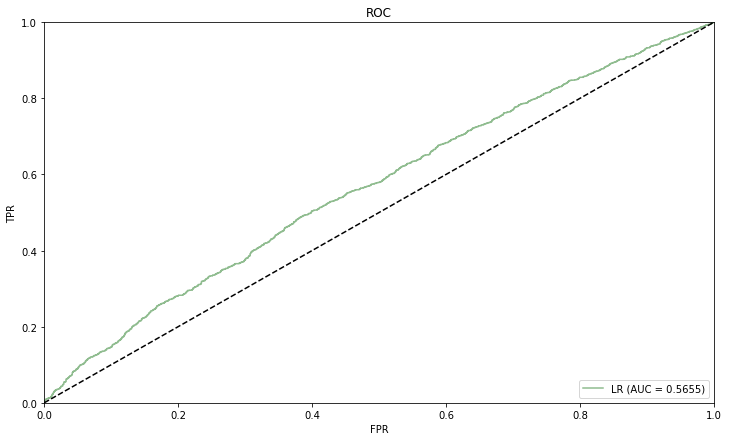

In [128]:
fig = plt.figure(figsize = (12,7))

plt.plot(fpr_lr_best, tpr_lr_best, color = "darkseagreen", label = "LR (AUC = {:.4f})".format(auc_lr_best))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc = 'lower right')

plt.show()

In [129]:
print("Model accuracy = {:.4f}".format(acc_lr_best))

Model accuracy = 0.4912


This ultimately did not improve on our baseline at all. There are certainly computational advantages to working with fewer features (34 versus 228 originally) that are important to consider. Additionally, the performance of the model did not suffer drastically (~0.003 lower AUC than with all neighborhood features).